##### Mediapipe 人臉偵測 ( Face Detection )
這篇教學會使用 MediaPipe 的人臉偵測模型 ( Face Detection ) 偵測人臉，再透過 OpenCV 讀取攝影鏡頭影像進行偵測，\
最後也會介紹如何取得五官座標資訊，使用繪製形狀的方式，即時在攝影畫面加上卡通的眼睛。

參考「[使用 MediaPipe ( 2023 年版 )](https://steam.oxxostudio.tw/category/python/ai/ai-mediapipe-2023.html)」，建立虛擬環境並安裝相關套件進行實作，注意 MediaPipe 需要使用 Python 3.9 的版本，\
如果高於 3.10 會無法安裝。

##### 使用 MediaPipe，偵測人臉 
在開發的資料夾裡新增一個 Python 檔案和一個名為 model 的資料夾，下載偵測模型 blaze_face_short_range.tflite 放在 model 的資料夾中，\
輸入下方的程式碼，執行後就可以看見白色外框正方形標記人臉，使用紅色小圓點標記五官位置。

下載模型：[blaze_face_short_range.tflite](https://storage.googleapis.com/mediapipe-models/face_detector/blaze_face_short_range/float16/latest/blaze_face_short_range.tflite)\
參考：[Face detection guide for Python](https://developers.google.com/mediapipe/solutions/vision/face_detector/python)

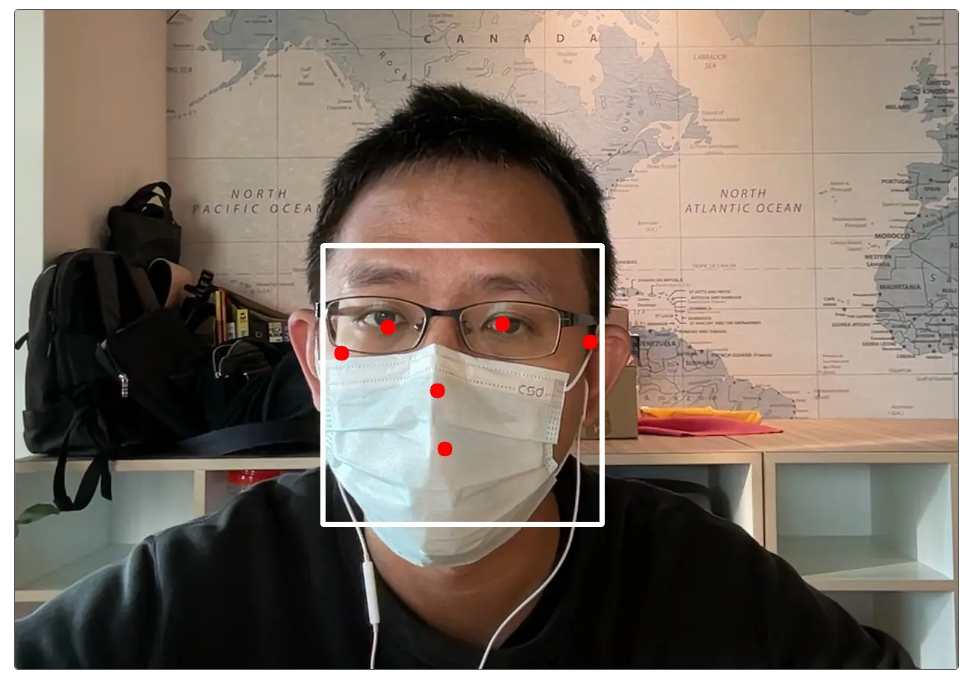

In [ ]:
import cv2
import numpy as np
import mediapipe as mp

# 設定 MediaPipe 的基本選項和臉部偵測器
BaseOptions = mp.tasks.BaseOptions #基本選項
FaceDetector = mp.tasks.vision.FaceDetector #臉部偵測器
FaceDetectorOptions = mp.tasks.vision.FaceDetectorOptions #臉部偵測器選項
VisionRunningMode = mp.tasks.vision.RunningMode #運行模式

# 人臉偵測設定
options = FaceDetectorOptions(
    base_options=BaseOptions(model_asset_path=r'Model/13/blaze_face_short_range.tflite'),
    running_mode=VisionRunningMode.IMAGE)

# 執行人臉偵測
with FaceDetector.create_from_options(options) as detector:
    cap = cv2.VideoCapture(0)               # 讀取攝影鏡頭
    while True:
        ret, frame = cap.read()             # 讀取影片的每一幀
        w = frame.shape[1]                  # 畫面寬度
        h = frame.shape[0]                  # 畫面高度
        mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame) # 轉換成 mediapipe 圖片物件
        detection_result = detector.detect(mp_image)  # 偵測人臉
        for detection in detection_result.detections:
            bbox = detection.bounding_box     # 人臉外框
            lx = bbox.origin_x                # 人臉左上 x 座標
            ly = bbox.origin_y                # 人臉左上 y 座標
            width = bbox.width                # 人臉寬度
            height = bbox.height              # 人臉高度
            cv2.rectangle(frame,(lx,ly),(lx+width,ly+height),(0,0,255),5) # opencv 繪圖
            # 取出人臉特徵值
            for keyPoint in detection.keypoints:
                cx = int(keyPoint.x*w)      # 特徵值 x 座標，乘以畫面寬度，因為特徵值是比例
                cy = int(keyPoint.y*h)      # 特徵值 y 座標，乘以畫面高度，因為特徵值是比例
                cv2.circle(frame,(cx,cy),10,(0,0,255),-1) 
        if not ret:
            print("Cannot receive frame")   # 如果讀取錯誤，印出訊息
            break
        cv2.imshow('oxxostudio', frame)     # 如果讀取成功，顯示該幀的畫面
        if cv2.waitKey(10) == ord('q'):     # 每一毫秒更新一次，直到按下 q 結束
            break
    cap.release()                           # 所有作業都完成後，釋放資源
    cv2.destroyAllWindows()                 # 結束所有視窗

##### 標記多張人臉 
在上述的程式碼裡，detection_result.detections 是一個串列資料，透過串列紀錄「幾組」人臉，因此只要稍微修改程式碼，就可以用不同顏色標記不同人臉。

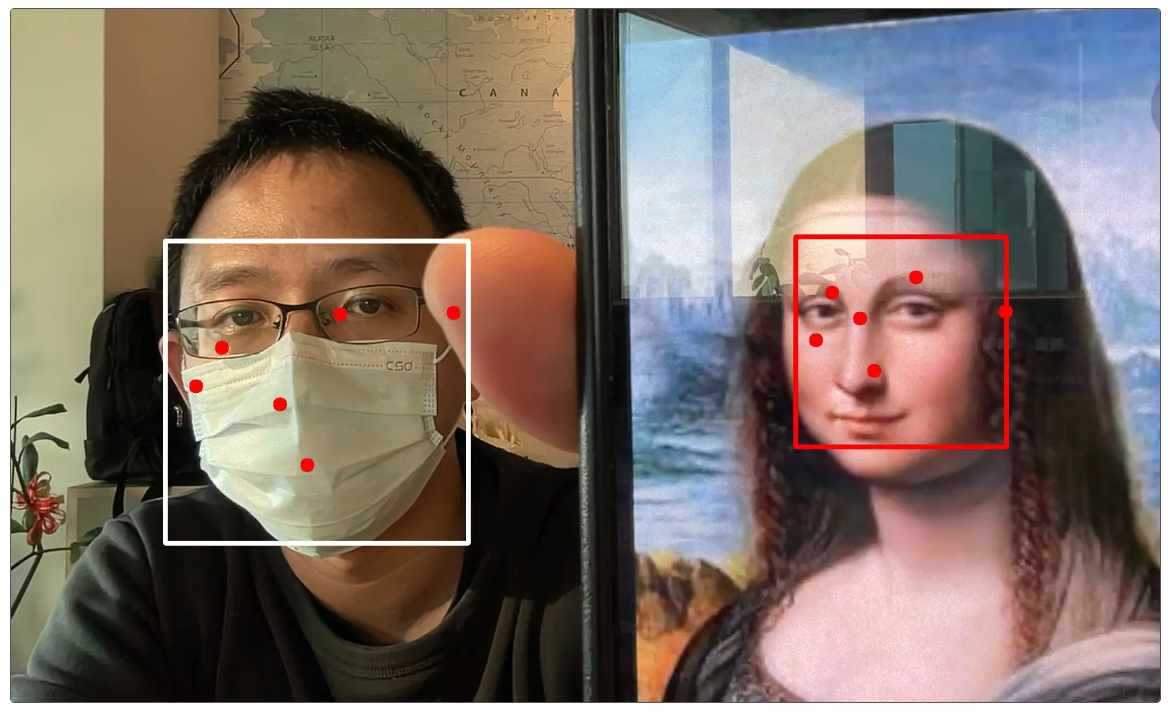

In [ ]:
import cv2
import numpy as np
import mediapipe as mp

# 設定 MediaPipe 的基本選項和臉部偵測器
BaseOptions = mp.tasks.BaseOptions #基本選項
FaceDetector = mp.tasks.vision.FaceDetector #臉部偵測器
FaceDetectorOptions = mp.tasks.vision.FaceDetectorOptions #臉部偵測器選項
VisionRunningMode = mp.tasks.vision.RunningMode #運行模式

# 人臉偵測設定
options = FaceDetectorOptions(
    base_options=BaseOptions(model_asset_path=r'Model/13/blaze_face_short_range.tflite'),
    running_mode=VisionRunningMode.IMAGE)

with FaceDetector.create_from_options(options) as detector:
    cap = cv2.VideoCapture(0)
    while True:
        ret, frame = cap.read()             # 讀取影片的每一幀
        w = frame.shape[1]
        h = frame.shape[0]
        mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame)
        detection_result = detector.detect(mp_image)
        colorArr = [(255,255,255),(0,0,255)]   # 定義標記人臉的顏色
        faceNum = 0   # 人臉串列位置從 0 開始
        for detection in detection_result.detections:
            if faceNum > 1:
                color = (0,255,255)   # 如果人臉數量大於 2，就都用黃色標記
            else:
                color = colorArr[faceNum]  # 如果人臉數量小於等於 2，使用串列定義的顏色
            bbox = detection.bounding_box
            lx = bbox.origin_x
            ly = bbox.origin_y
            width = bbox.width
            height = bbox.height
            cv2.rectangle(frame,(lx,ly),(lx+width,ly+height),color,5)
            for keyPoint in detection.keypoints:
                cx = int(keyPoint.x*w)
                cy = int(keyPoint.y*h)
                cv2.circle(frame,(cx,cy),10,(0,0,255),-1) 
            faceNum = faceNum + 1      # 人臉數量增加 1
        if not ret:
            print("Cannot receive frame")
            break
        cv2.imshow('oxxostudio', frame)
        if cv2.waitKey(10) == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()